# Fitness Occlusion Dataset - Demo Notebook

Demo 1: Filtering/querying the dataset based on the amount of avatar occlusion.  
Demo 2: Visualizing labels for a specific video.

Note: this notebook relies on the `infinity-tools` python module, which can be installed by following the [installation instructions](https://github.com/toinfinityai/infinity-tools#installation).

In [1]:
import os
import cv2
import json
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from IPython.display import clear_output
from infinity_tools.visionfit import vis
from infinity_tools.common.vis.videos import (
    parse_video_frames,
    stack_videos,
)

## Demo 1: Filter dataset by occlusion
We first show how you can filter the dataset based on the average amount of avatar occlusion and view representative examples ranging from minimal to severe occlusion amounts.

In [2]:
# specify location of the unzipped exercise folder
exercise_folder = "PATH_TO_SINGLE_EXERCISE_DATA_FOLDER"

In [3]:
# iterate over annotation jsons for each video and extract labels
json_paths = sorted(glob.glob(os.path.join(exercise_folder, "*_labels.json")))
metadata = []
for json_path in json_paths:
    coco = COCO(json_path)
    percent_occlusion = []
    for ann in coco.anns.values():
        if coco.cats[ann["category_id"]]["name"] != "person":
            # skip any non-person annotations (e.g. for dumbbells)
            continue
        percent_occlusion.append(ann["percent_occlusion"])
    avg_percent_occlusion = np.mean(percent_occlusion)  # average across frames
    metadata.append({
        "video_number": os.path.basename(json_path).split("_")[0],
        "avg_percent_occlusion": avg_percent_occlusion,
    })
metadata_df = pd.DataFrame(metadata)
clear_output()
display(metadata_df.head())

,video_number,avg_percent_occlusion
0,00000,23.146343
1,00001,28.452710
2,00002,13.333429
3,00003,42.062412
4,00004,37.623566


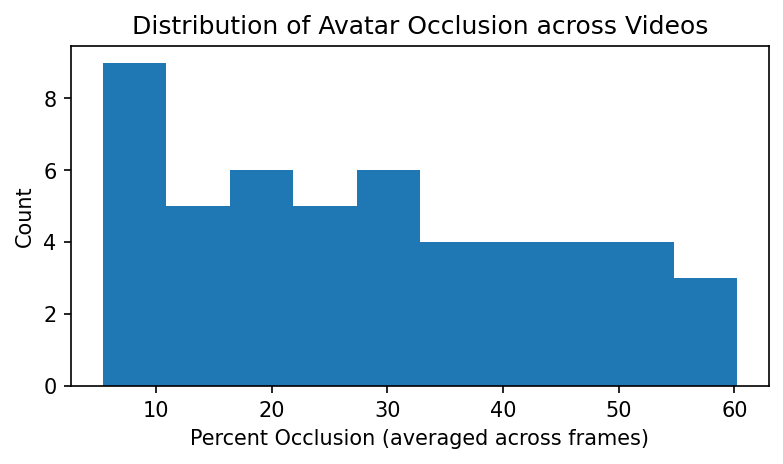

In [4]:
num_bins = 10
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.hist(metadata_df["avg_percent_occlusion"], bins=num_bins)
ax.set_title("Distribution of Avatar Occlusion across Videos")
ax.set_xlabel("Percent Occlusion (averaged across frames)")
ax.set_ylabel("Count")
plt.show()

We can see that the dataset a curated distribution of occlusion ranging between roughly 5 and 60%. Below we visualize examples across this spectrum.

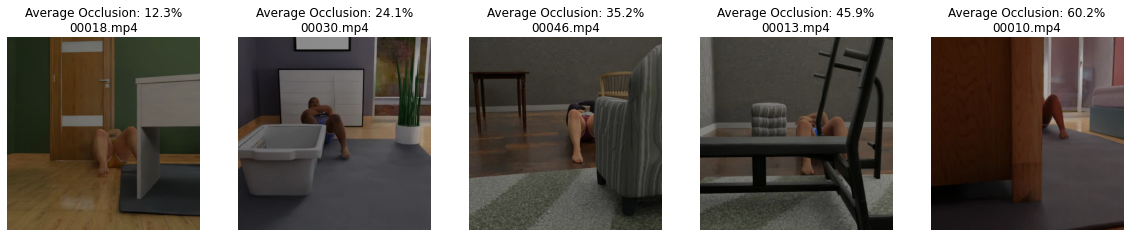

In [5]:
num_to_plot = 5
examples_to_plot = (
    metadata_df
    .sample(n=num_to_plot, random_state=123)
    .sort_values(by="avg_percent_occlusion", ascending=True)
)

fig,ax = plt.subplots(1, num_to_plot, figsize=(4*num_to_plot,4))
for i, (_, video_data) in enumerate(examples_to_plot.iterrows()):
    video_number = video_data['video_number']
    percent_occlusion = video_data['avg_percent_occlusion']
    video_path = os.path.join(exercise_folder, f"{video_number}.mp4")
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()
    ax[i].imshow(img[:,:,::-1])
    ax[i].set_title(f"Average Occlusion: {percent_occlusion:0.1f}%\n{video_number}.mp4")
    ax[i].axis("off")
plt.show()

## Demo 2: Visualize Labels

In this next demo, we'll visualize a few of the different labels provided in Fitness Occlusion Dataset that can be used for training. We use the sample data provided in this repo.

In [6]:
def visualize_all_labels(video_rgb_path: str):

    output_directory = os.path.dirname(video_rgb_path)
    
    video_json_path = video_rgb_path.replace(".mp4", "_labels.json")
    zipped_video_path = video_rgb_path.replace(".mp4", "_segmentation.zip")
    job_json_path = video_rgb_path.replace(".mp4", "_params.json")
    job_params = json.load(open(job_json_path))["params"]

    video_rgb_extracted = video_rgb_path.replace(".mp4", "")
    os.makedirs(video_rgb_extracted, exist_ok=True)
    vis.unzip(zipped_video_path, video_rgb_extracted)

    imgs = parse_video_frames(video_rgb_path)
    fps = int(job_params["frame_rate"])
    rep_count = vis.parse_rep_count_from_json(video_json_path)
    coco = COCO(video_json_path)

    bounding_box_path = vis.create_bounding_boxes_video(os.path.join(output_directory, "bounding_box.mp4"), imgs, fps, coco)
    skeleton_path = vis.create_keypoint_connections_video(os.path.join(output_directory, "skeleton.mp4"), imgs, fps, coco)
    cuboids_path = vis.create_cuboids_video(os.path.join(output_directory, "cuboids.mp4"), imgs, fps, coco)
    _3D_path = vis.create_3D_keypoints_video(
        os.path.join(output_directory, "3D_keypoints.mp4"),
        fps,
        coco,
        150,
        imgs.shape[1],
        imgs.shape[2],
    )
    segmentation_path = vis.create_segmentation_video(
        os.path.join(output_directory, "segmentation.mp4"),
        video_rgb_extracted,
        fps,
        imgs.shape[1],
        imgs.shape[2],
    )


    row1_paths = [video_rgb_path, segmentation_path, bounding_box_path]
    label_videos_row_1 = stack_videos(row1_paths, axis=2, output_path=os.path.join(output_directory, "row1.mp4"))
    
    row2_paths = [cuboids_path, skeleton_path, _3D_path]
    label_videos_row_2 = stack_videos(row2_paths, axis=2, output_path=os.path.join(output_directory, "row2.mp4"))
    
    label_grid_path = stack_videos(
        paths=[label_videos_row_1, label_videos_row_2], 
        axis=1,
        output_path=os.path.join(output_directory, "merged_without_ts.mp4")
    )
    
    ts_path = vis.animate_time_series(
        os.path.join(output_directory, "timeseries.mp4"),
        rep_count,
        fps,
        width_in_pixels=imgs.shape[1] * 2,
        height_in_pixels=imgs.shape[1] * 2,
    )

    merged_video_path = stack_videos(
        paths=[label_grid_path, ts_path], 
        axis=2, 
        output_path=os.path.join(output_directory, "labels.mp4")
    )
    
    # cleanup and remove intermediate files
    remove_paths = row1_paths[1:] + row2_paths + [label_videos_row_1, label_videos_row_2, label_grid_path, ts_path]
    for e in remove_paths:
        os.remove(e)
    shutil.rmtree(video_rgb_extracted)
    clear_output()
    
    return merged_video_path

In [7]:
video_rgb_path = "./sample_data/00004.mp4"
labels_video_path = visualize_all_labels(video_rgb_path)
print(f"The resulting labels video can be viewed at: {labels_video_path}")

The resulting labels video can be viewed at: ./sample_data/labels.mp4
